<a href="https://colab.research.google.com/github/frostbitepy/AirflowPipeline01/blob/master/Proyecto_Pulsar_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Cargar un archivo CSV
dataset = pd.read_csv("water_potability.csv")

In [ ]:
dataset.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [ ]:
# Función para describir y contar NaN
def describe_and_count_nan(dataframe):
    # Describir el DataFrame
    description = dataframe.describe()

    # Contar NaN en cada columna
    nan_counts = dataframe.isna().sum()

    return description, nan_counts

# Función para visualizar atributos
def visualize_attributes(dataframe):
    # Obtener una matriz de correlación de los atributos
    corr_matrix = dataframe.corr()

    # Crear un mapa de calor de la matriz de correlación
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Matriz de Correlación de Atributos')
    plt.show()

# Función para dividir el conjunto de datos en train, cross-validation y test sets
def split_dataset(dataframe, train_ratio=0.6, cv_ratio=0.2, test_ratio=0.2, random_state=None):
    # Dividir el conjunto de datos en entrenamiento (train) y el resto (temp)
    train, temp = train_test_split(dataframe, test_size=(1 - train_ratio), random_state=random_state)

    # Dividir el conjunto de "temp" en validación cruzada (cross-validation) y prueba (test)
    cv, test = train_test_split(temp, test_size=test_ratio / (test_ratio + cv_ratio), random_state=random_state)

    return train, cv, test

# Función para seleccionar las variables más relevantes en función de la correlación con la variable objetivo
def select_top_correlated_features(dataframe, target_variable, num_features=3):
    # Calcula la matriz de correlación
    correlation_matrix = dataframe.corr()

    # Obtiene las correlaciones con la variable objetivo en valor absoluto y ordenadas de mayor a menor
    correlation_with_target = correlation_matrix[target_variable].abs().sort_values(ascending=False)

    # Selecciona las mejores variables (excluye la variable objetivo)
    selected_variables = correlation_with_target[1:num_features + 1].index

    return selected_variables

# Funcion para normalizar los datos en el DataFrame utilizando la transformación estándar (media 0, varianza 1)
def normalize_data(dataframe, columns_to_normalize=None):

    if columns_to_normalize is None:
        # Si no se proporcionan columnas específicas, normalizar todas las columnas numéricas
        numeric_columns = dataframe.select_dtypes(include=[float, int]).columns
    else:
        # Normalizar solo las columnas especificadas
        numeric_columns = columns_to_normalize

    # Crear un objeto StandardScaler
    scaler = StandardScaler()

    # Aplicar la normalización a las columnas numéricas seleccionadas
    dataframe[numeric_columns] = scaler.fit_transform(dataframe[numeric_columns])

    return dataframe

# Entrena un modelo de regresión logística con diferentes valores de learning rate.
def train_model_with_learning_rates(data, learning_rates, target_variable='Class'):
    # Almacenar resultados
    results = {}

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X = data.drop(columns=[target_variable])
    y = data[target_variable]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for lr in learning_rates:
        # Crear un modelo de regresión logística con el valor de learning rate
        # model = LogisticRegression(C=1/lr, random_state=42)

        # Crear un modelo de regresión logística con el valor de learning rate y mayor número de iteraciones
        model = LogisticRegression(C=1/lr, max_iter=1000, random_state=42)

        # Entrenar el modelo
        model.fit(X_train, y_train)

        # Hacer predicciones en el conjunto de prueba
        y_pred = model.predict(X_test)

        # Calcular la precisión del modelo
        accuracy = accuracy_score(y_test, y_pred)

        # Almacenar los resultados en el diccionario
        results[lr] = accuracy

    return results

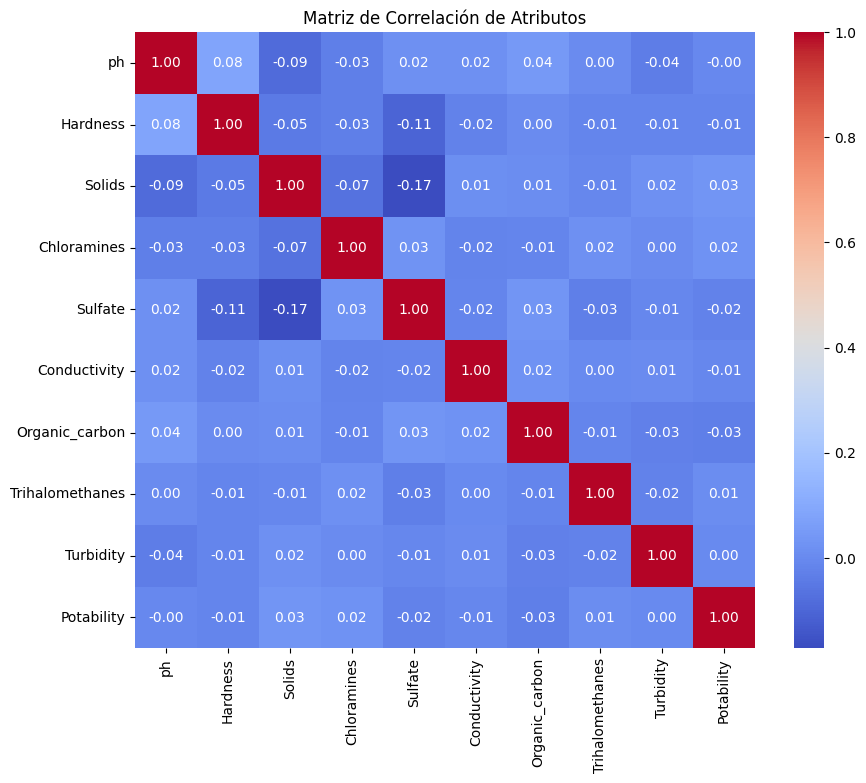

In [ ]:
# Visualizar atributos
visualize_attributes(dataset)

In [ ]:
# Dividir el conjunto de datos en entrenamiento, validación cruzada y prueba
train_set, cv_set, test_set = split_dataset(dataset)

In [ ]:
# Seleccionar las variables más relevantes
selected_variables = select_top_correlated_features(train_set, target_variable='Class', num_features=3)
print("Variables seleccionadas para la predicción:")
print(selected_variables)

Variables seleccionadas para la predicción:
Index(['EK', 'Skewness', 'Mean_Integrated'], dtype='object')


In [ ]:
# Normalizar los datos
train_set = normalize_data(train_set, columns_to_normalize=selected_variables)
cv_set = normalize_data(cv_set, columns_to_normalize=selected_variables)
test_set = normalize_data(test_set, columns_to_normalize=selected_variables)

In [ ]:
# Valores de learning rate para probar
learning_rates_to_test = [0.001, 0.01, 0.1, 1, 10]

In [ ]:
# Entrenar un modelo de regresión logística con diferentes learning rates
results = train_model_with_learning_rates(train_set, learning_rates_to_test)

In [ ]:
# Encontrar el mejor valor de learning rate
best_learning_rate = max(results, key=results.get)
print(f"Mejor learning rate encontrado: {best_learning_rate}, Precisión: {results[best_learning_rate]}")

Mejor learning rate encontrado: 0.1, Precisión: 0.9739292364990689


In [ ]:
# Calcular el valor de C basado en el mejor learning rate
best_C = 1 / best_learning_rate

# Entrenar el modelo final con el mejor learning rate
final_model = LogisticRegression(C=best_C, max_iter=1000, random_state=42)
final_model.fit(train_set.drop(columns=['Class']), train_set['Class'])

LogisticRegression(C=10.0, max_iter=1000, random_state=42)

In [ ]:
# Supongamos que ya has dividido tus datos en train_set, cv_set y test_set
# train_set se utilizó para entrenar y ajustar hiperparámetros
# cv_set se utilizó para la validación cruzada
# test_set es el conjunto de prueba que no se ha utilizado para ajustar hiperparámetros

# Entrena el modelo con los mejores hiperparámetros
best_C = 1 / best_learning_rate  # Utiliza el valor de C basado en el mejor learning rate
final_model = LogisticRegression(C=best_C, max_iter=1000, random_state=42)
final_model.fit(train_set.drop(columns=['Class']), train_set['Class'])

# Realiza predicciones en el conjunto de prueba
X_test = test_set.drop(columns=['Class'])
y_test = test_set['Class']
y_pred = final_model.predict(X_test)

# Evalúa el rendimiento del modelo en el conjunto de prueba
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Precisión en el conjunto de prueba: {accuracy}")
print("Reporte de clasificación en el conjunto de prueba:")
print(report)

Precisión en el conjunto de prueba: 0.9804469273743017
Reporte de clasificación en el conjunto de prueba:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3252
           1       0.93      0.85      0.89       328

    accuracy                           0.98      3580
   macro avg       0.96      0.92      0.94      3580
weighted avg       0.98      0.98      0.98      3580



In [ ]:
import pickle

# Suponiendo que 'final_model' es tu modelo entrenado
# Abre un archivo en modo de escritura binaria (wb) donde se guardará el modelo
with open('modelo_entrenado.pkl', 'wb') as file:
    # Guarda el modelo en el archivo
    pickle.dump(final_model, file)

print("Modelo entrenado guardado en 'modelo_entrenado.pkl'")

Modelo entrenado guardado en 'modelo_entrenado.pkl'


In [ ]:
# main.py file

"""
import argparse
import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Función para cargar el modelo y el normalizador
def cargar_modelo_y_normalizador(modelo_path, normalizador_path):
    with open(modelo_path, 'rb') as model_file:
        modelo = pickle.load(model_file)

    with open(normalizador_path, 'rb') as scaler_file:
        normalizador = pickle.load(scaler_file)

    return modelo, normalizador

# Función para realizar predicciones
def predecir(modelo, normalizador, datos_entrada):
    # Aplica la transformación de normalización a los datos de entrada
    datos_normalizados = normalizador.transform(datos_entrada)

    # Realiza predicciones
    predicciones = modelo.predict(datos_normalizados)

    return predicciones

if __name__ == "__main__":
    # Configurar argumentos desde la terminal
    parser = argparse.ArgumentParser(description="Realizar predicciones con un modelo entrenado.")
    parser.add_argument("--modelo", required=True, help="Ruta al archivo del modelo entrenado (pickle).")
    parser.add_argument("--normalizador", required=True, help="Ruta al archivo del normalizador (pickle).")
    parser.add_argument("--entrada", required=True, help="Ruta al archivo CSV de entrada para predicciones.")
    args = parser.parse_args()

    # Cargar el modelo y el normalizador
    modelo, normalizador = cargar_modelo_y_normalizador(args.modelo, args.normalizador)

    # Cargar datos de entrada para predicciones desde un archivo CSV
    datos_entrada = pd.read_csv(args.entrada)

    # Realizar predicciones
    predicciones = predecir(modelo, normalizador, datos_entrada)

    # Imprimir las predicciones
    print("Predicciones:")
    print(predicciones)
"""